<div style="text-align: center;">
  <img src="https://github.com/Hack-io-Data/Imagenes/blob/main/01-LogosHackio/logo_naranja@4x.png?raw=true" alt="esquema" />
</div>

# Preprocesamiento de Datos para un Modelo de Clasificación

Nuestro equipo de riesgo ha identificado la necesidad de construir un modelo de clasificación para detectar transacciones potencialmente fraudulentas o anómalas. El éxito de este modelo permitirá identificar patrones en los datos y reducir pérdidas económicas para nuestros clientes y la empresa. Tu trabajo para hoy será preparar los datos proporcionados para desarrollar un modelo de clasificación que prediga la probabilidad de que una transacción sea “Normal” o “Anómala”, basándose en las características de las transacciones. Dentro de las tareas que tienes que realizar hoy deben estar incluidas las siguientes: 


1. **Análisis exploratorio de datos (EDA):**

   - Visualizar la distribución de las principales variables.

   - Explorar relaciones entre las características y la variable objetivo (`TransactionStatus`).


2. **Limpieza de datos:**

   - Identificar y tratar valores nulos.

   - Eliminar duplicados si existen.

   - Asegurar que las variables tienen el tipo de dato correcto.

   - etc. 

3. **Transformación de variables:**

   - Normalizar o escalar variables numéricas según sea necesario.

   - Codificar variables categóricas con técnicas como One-Hot Encoding, Target Encoding u Ordinal Encoding, según corresponda.

   - Crear variables derivadas útiles, como:

     - Frecuencia de transacciones de cada cliente.

     - Diferencia de tiempo entre transacciones consecutivas.

     - Ratio entre el saldo posterior y el monto de la transacción.

## Datos Proporcionados

El archivo de datos que analizarán contiene transacciones reales registradas por una compañia. A continuación, se describen las principales columnas que deberán preprocesar:


- **TransactionID:** Identificador único alfanumérico para cada transacción.

- **AccountID:** Identificador único de la cuenta asociada a la transacción.

- **TransactionAmount:** Monto de la transacción.

- **TransactionDate:** Fecha y hora de la transacción.

- **TransactionType:** Tipo de transacción (Crédito o Débito).

- **Location:** Ubicación geográfica donde ocurrió la transacción.

- **DeviceID:** Identificador del dispositivo usado para la transacción.

- **IP Address:** Dirección IP asociada a la transacción, que puede cambiar ocasionalmente para algunas cuentas.

- **MerchantID:** Identificador único para los comercios, mostrando tanto comerciantes preferidos como atípicos para cada cuenta.

- **AccountBalance:** Saldo restante en la cuenta después de la transacción.

- **PreviousTransactionDate:** Fecha y hora de la transacción anterior en la cuenta.

- **Channel:** Canal utilizado para realizar la transacción (en línea, sucursal, cajero automático, etc.).

- **CustomerAge:** Edad del titular de la cuenta.

- **CustomerOccupation:** Ocupación del titular de la cuenta (por ejemplo, Doctor, Ingeniero, Estudiante, Jubilado), reflejando patrones de ingresos.

- **TransactionDuration:** Duración de la transacción en segundos.

- **LoginAttempts:** Número de intentos de inicio de sesión antes de realizar la transacción.

- **TransactionStatus:** Variable objetivo que indica si la transacción es "Normal" o "Anómala".


In [ ]:
# Tratamiento de datos
# -----------------------------------------------------------------------
import numpy as np
import pandas as pd
import pickle

# Otros objetivos
# -----------------------------------------------------------------------
import math

# Gráficos
# -----------------------------------------------------------------------
import seaborn as sns
import matplotlib.pyplot as plt

from itertools import product, combinations
from sklearn.preprocessing import MinMaxScaler, Normalizer, StandardScaler, RobustScaler
from sklearn.neighbors import LocalOutlierFactor # para detectar outliers usando el método LOF
from sklearn.ensemble import IsolationForest # para detectar outliers usando el metodo IF

# Para imputar nulos
# -------------------------------------------------------------------------
from sklearn.experimental import enable_iterative_imputer  # Habilita IterativeImputer
from sklearn.impute import IterativeImputer
from sklearn.impute import KNNImputer

# Para tratar el problema de desbalance
# -----------------------------------------------------------------------
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTETomek

from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, LabelEncoder #, TargetEncoder # para poder aplicar los métodos de OneHot, Ordinal,  Label y Target Encoder 

from category_encoders import TargetEncoder 

In [110]:
import sys
import os
sys.path.append(os.path.abspath('../'))

In [111]:
# Importamos el sopooporte de procesamiento de nuestro src
from src import soporte_preprocesamiento as sp

In [112]:
from src import soporte_outliers as so

In [113]:
from src import soporte_encoding as se

In [114]:
from scipy.stats import chi2_contingency

In [115]:
# Instrucción para visualizar todas las columnas de un dataFrame
pd.set_option('display.max_columns', None)

In [116]:
df = pd.read_csv("datos/financial_data.csv")


In [117]:
df.head()

,transaction_id,customer_id,merchant_id,amount,transaction_time,is_fraudulent,card_type,location,purchase_category,customer_age,transaction_description
0,1,1082,2027,5758.59,2023-01-01 00:00:00,0,MasterCard,City-30,Gas Station,43,Purchase at Merchant-2027
1,2,1015,2053,1901.56,2023-01-01 00:00:01,1,Visa,City-47,Online Shopping,61,Purchase at Merchant-2053
2,3,1004,2035,1248.86,2023-01-01 00:00:02,1,MasterCard,City-6,Gas Station,57,Purchase at Merchant-2035
3,4,1095,2037,7619.05,2023-01-01 00:00:03,1,Discover,City-6,Travel,59,Purchase at Merchant-2037
4,5,1036,2083,1890.10,2023-01-01 00:00:04,1,MasterCard,City-34,Retail,36,Purchase at Merchant-2083


## EDA

In [118]:
sp.exploracion_datos(df)

El número de filas es 10000 y el número de columnas es 11

----------

En este conjunto de datos tenemos 0 valores duplicados

----------

Los columnas con valores nulos y sus porcentajes son: 


Series([], dtype: float64)


----------

Las principales estadísticas de las variables númericas son:


,count,mean,std,min,25%,50%,75%,max
transaction_id,10000.0,5000.500000,2886.895680,1.00,2500.750,5000.500,7500.2500,10000.00
customer_id,10000.0,1051.272300,28.864062,1001.00,1026.000,1052.000,1076.0000,1100.00
merchant_id,10000.0,2050.486600,28.877801,2001.00,2025.000,2050.000,2076.0000,2100.00
amount,10000.0,4958.381617,2899.699675,10.61,2438.175,4943.945,7499.3125,9999.75
is_fraudulent,10000.0,0.506800,0.499979,0.00,0.000,1.000,1.0000,1.00
customer_age,10000.0,44.047500,15.321707,18.00,31.000,44.000,57.0000,70.00



----------

Las principales estadísticas de las variables categóricas son:


,count,unique,top,freq
transaction_time,10000,10000,2023-01-01 02:46:23,1
card_type,10000,4,Discover,2633
location,10000,50,City-7,223
purchase_category,10000,6,Travel,1694
transaction_description,10000,100,Purchase at Merchant-2016,120



----------

Las características principales del dataframe son:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   transaction_id           10000 non-null  int64  
 1   customer_id              10000 non-null  int64  
 2   merchant_id              10000 non-null  int64  
 3   amount                   10000 non-null  float64
 4   transaction_time         10000 non-null  object 
 5   is_fraudulent            10000 non-null  int64  
 6   card_type                10000 non-null  object 
 7   location                 10000 non-null  object 
 8   purchase_category        10000 non-null  object 
 9   customer_age             10000 non-null  int64  
 10  transaction_description  10000 non-null  object 
dtypes: float64(1), int64(5), object(5)
memory usage: 859.5+ KB


None

Observamos que no tenemos nulos ni duplicados.

Procedemos a hacer un analisis visual de las distribuciones de las variables numéricas y categóricas

In [119]:
visualizador =sp.Visualizador(df)

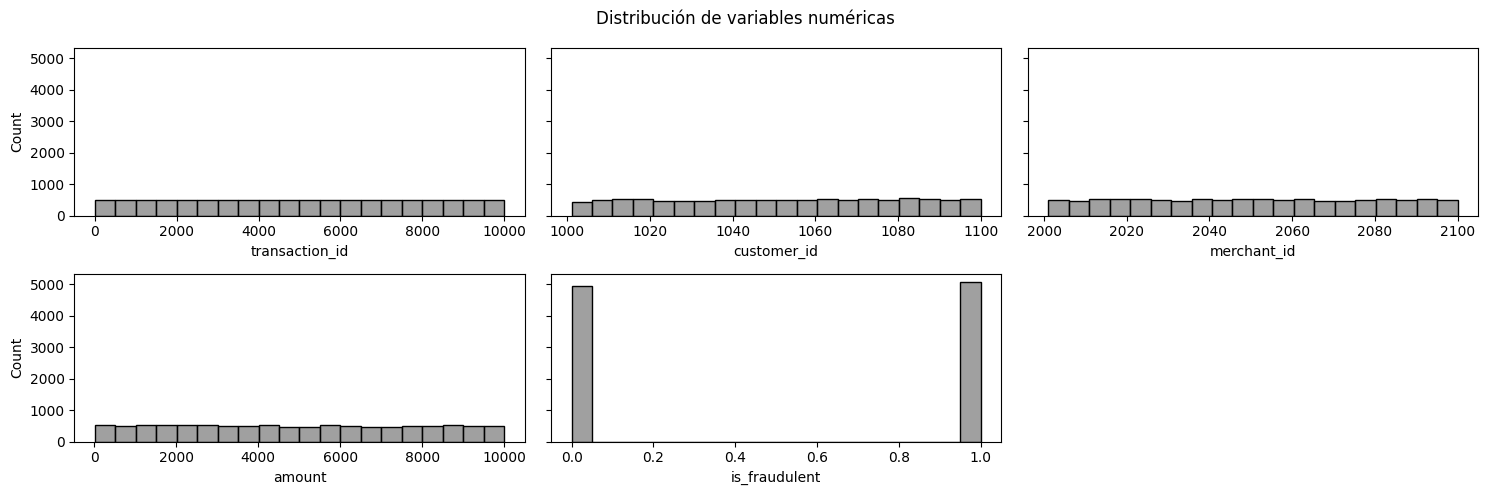

In [120]:
visualizador.plot_numericas()

A partir de la gráfica, podemos extraer varias conclusiones:

Los identificadores merchant_id y customer_id corresponden al vendedor y al cliente, respectivamente, son identificadores únicos. Por lo tanto, son variables categóricas (actúan como etiquetas) y no numéricas. Las mantendremos en el análisis, ya que podrían existir relaciones entre el fraude y cada uno de ellos.

El transaction_id, es un identificador único para cada transacción, puede ser eliminado del conjunto de datos.

La variable is_fraudulent es de tipo categórico, dado que sus valores son 0 y 1 y no es una variable continua. Por ello, ajustamos su tipo de dato para que sea categórica.

Las variables numéricas identificadas son la edad (customer_age) y la cantidad (amount).

Además, hemos notado que la columna transaction_description contiene la misma información que merchant_id, por lo que procederemos a eliminarla. También, eliminaremos transaction_time, ya que presenta datos erróneos con incrementos secuenciales de un segundo en una misma fecha.

In [121]:
df.drop(columns=["transaction_id", "transaction_description", "transaction_time"], inplace=True)
df[["customer_id", "merchant_id"]] = df[["customer_id", "merchant_id"]].astype(str)

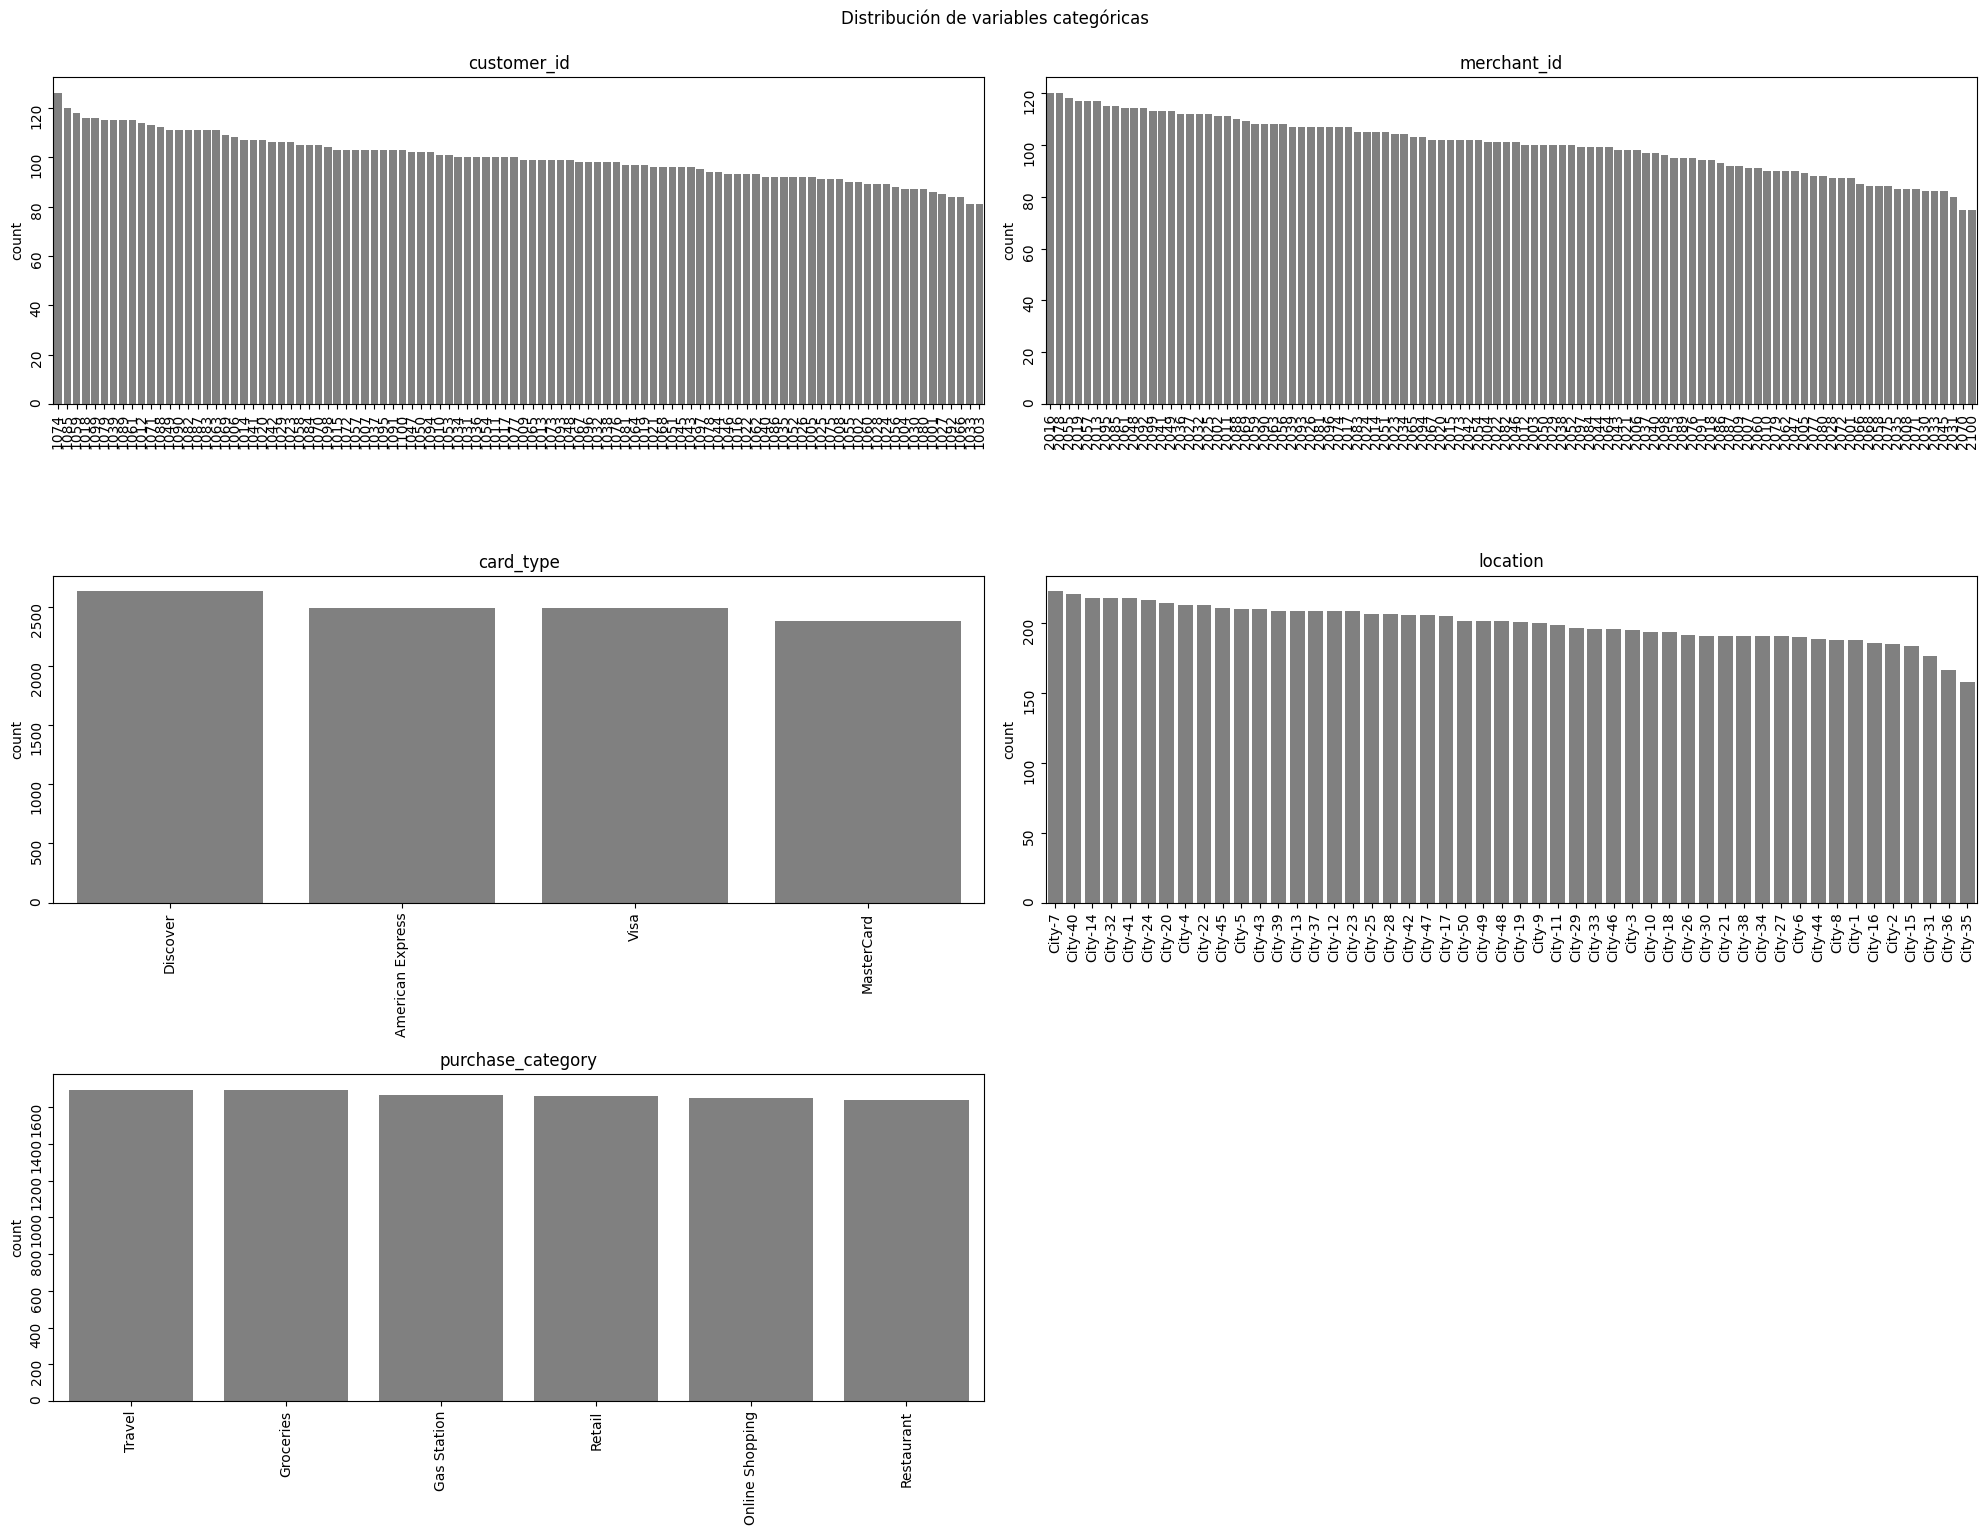

In [122]:
visualizador.plot_categoricas()

A simple vista, no parece que haya desbalanceo. En purchase_category las categoorías parecen estar muy equilibradas, en card_type tendremos que hacer una comprobación.

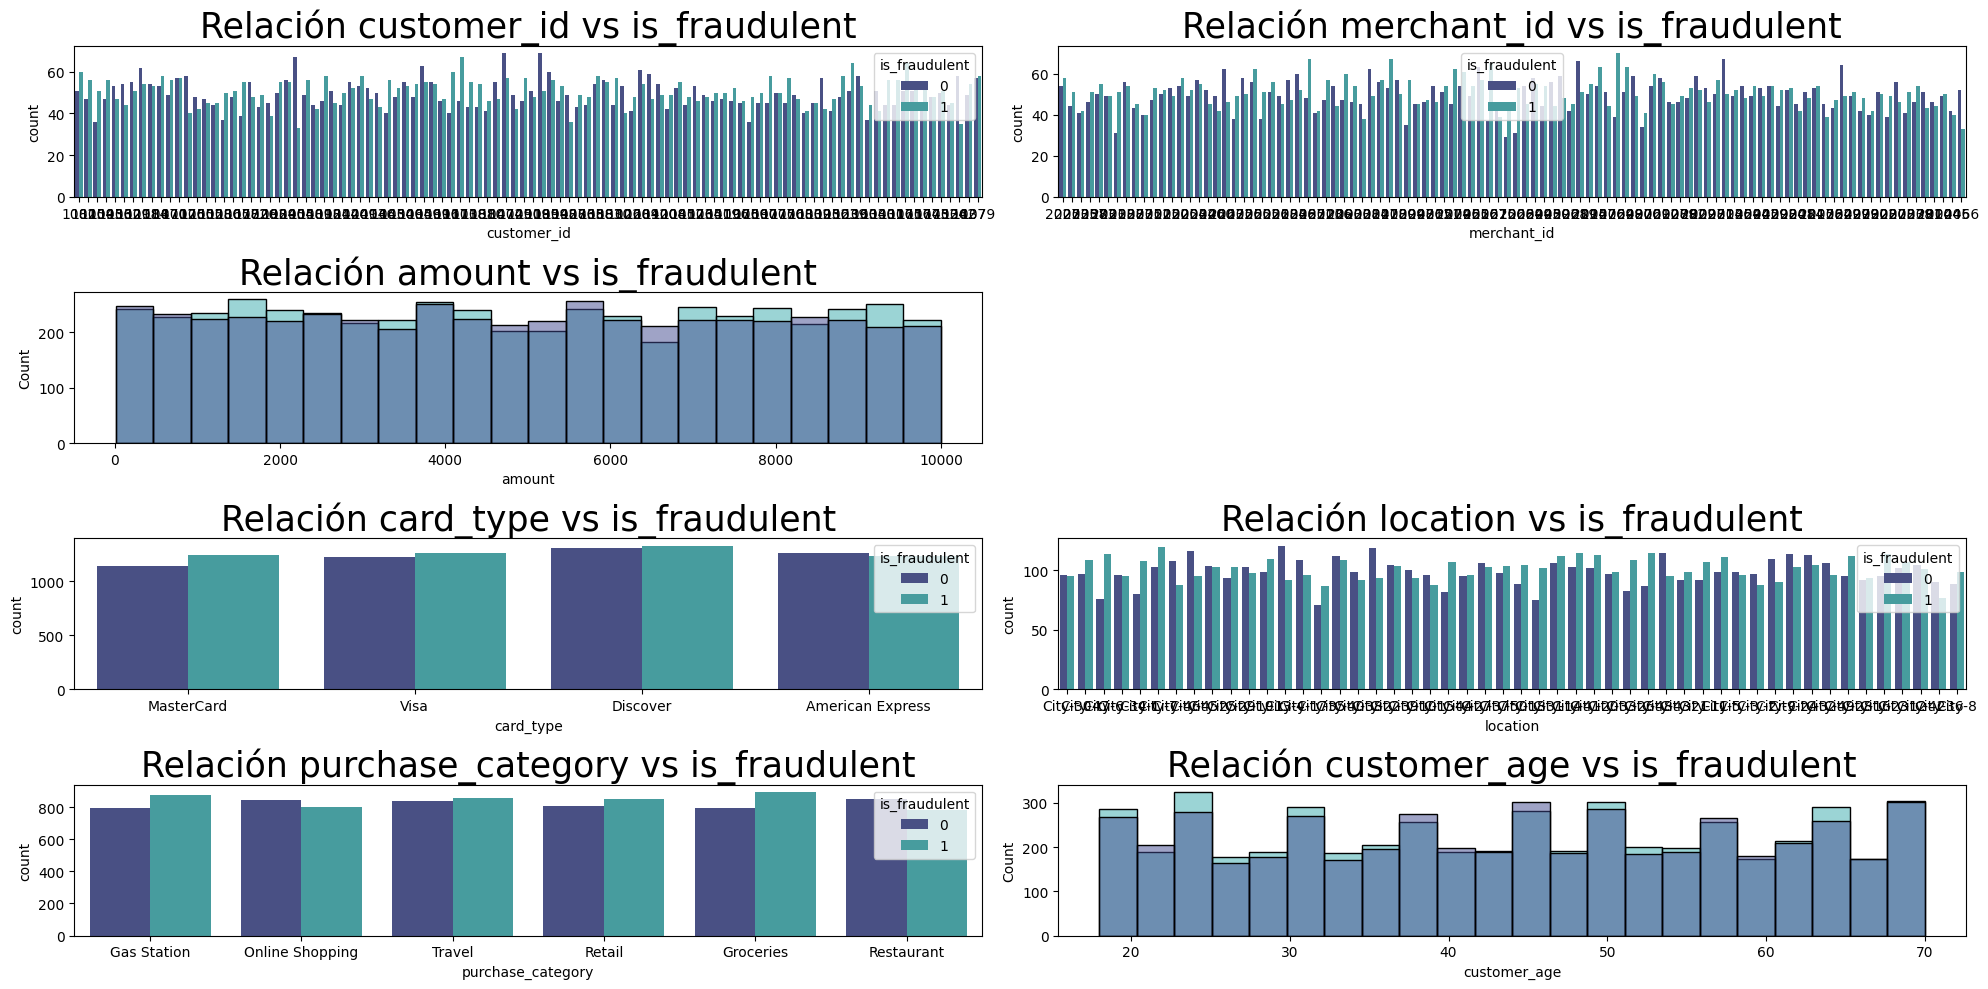

In [123]:
visualizador.plot_relacion("is_fraudulent")

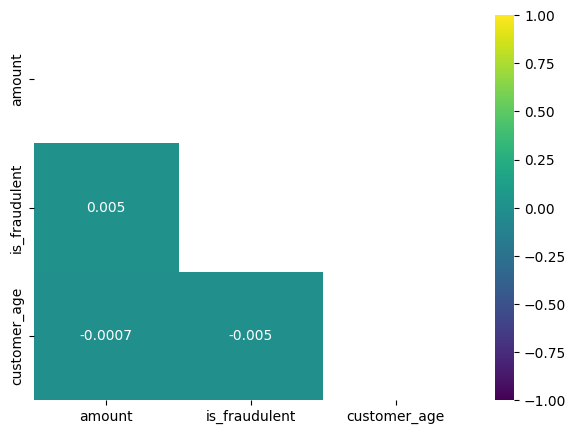

In [124]:
visualizador.correlacion()

Vemos que las correlaciones entre variables son muy débiles, así que no podemos eliminar ninguna del modelo porque aporte la misma información que otra.

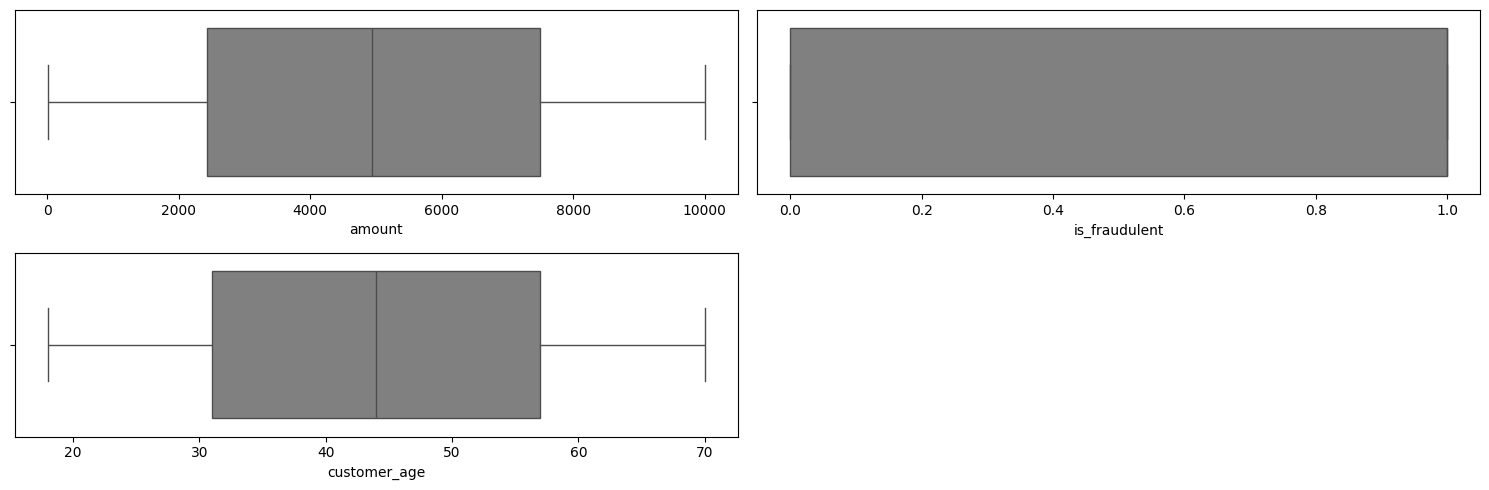

In [125]:
visualizador.deteccion_outliers()

A la vista de este gráfico, concluimos que no hay outliers univaraidos.

## ENCODING

In [126]:
df_cat=df.select_dtypes("O")
lista_categoricas=df_cat.columns

In [127]:
sp.detectar_orden_var_cat(df,lista_categoricas,"is_fraudulent")

Evaluando la variable CUSTOMER_ID


is_fraudulent,0,1
customer_id,,
1001,44,42
1002,45,45
1003,37,44
1004,36,51
1005,47,45
...,...,...
1096,46,52
1097,45,50
1098,46,58


La variable customer_id NO tiene orden.
_________________________ 

Evaluando la variable MERCHANT_ID


is_fraudulent,0,1
merchant_id,,
2001,45,42
2002,59,52
2003,46,54
2004,49,52
2005,38,51
...,...,...
2096,59,48
2097,53,46
2098,44,52


La variable merchant_id NO tiene orden.
_________________________ 

Evaluando la variable CARD_TYPE


is_fraudulent,0,1
card_type,,
American Express,1262,1232
Discover,1304,1329
MasterCard,1140,1243
Visa,1226,1264


La variable card_type NO tiene orden.
_________________________ 

Evaluando la variable LOCATION


is_fraudulent,0,1
location,,
City-1,80,108
City-10,100,94
City-11,92,107
City-12,102,107
City-13,99,110
City-14,106,112
City-15,96,88
City-16,92,94
City-17,109,96


La variable location NO tiene orden.
_________________________ 

Evaluando la variable PURCHASE_CATEGORY


is_fraudulent,0,1
purchase_category,,
Gas Station,792,874
Groceries,796,896
Online Shopping,847,804
Restaurant,851,785
Retail,808,853
Travel,838,856


La variable purchase_category tiene orden.
_________________________ 



In [128]:
diccionario_encoding = {
    "onehot": ["card_type", 'location'],
    "dummies": [],
    "ordinal": {},
    "label": [],
    "frequency": [],
    "target": ['customer_id', 'merchant_id', 'purchase_category']
}

In [129]:
encoding = se.Encoding(df, diccionario_encoding, "is_fraudulent")

In [130]:
df_one_hot = encoding.one_hot_encoding()
df_one_hot.head()

,customer_id,merchant_id,amount,is_fraudulent,purchase_category,customer_age,card_type_American Express,card_type_Discover,card_type_MasterCard,card_type_Visa,location_City-1,location_City-10,location_City-11,location_City-12,location_City-13,location_City-14,location_City-15,location_City-16,location_City-17,location_City-18,location_City-19,location_City-2,location_City-20,location_City-21,location_City-22,location_City-23,location_City-24,location_City-25,location_City-26,location_City-27,location_City-28,location_City-29,location_City-3,location_City-30,location_City-31,location_City-32,location_City-33,location_City-34,location_City-35,location_City-36,location_City-37,location_City-38,location_City-39,location_City-4,location_City-40,location_City-41,location_City-42,location_City-43,location_City-44,location_City-45,location_City-46,location_City-47,location_City-48,location_City-49,location_City-5,location_City-50,location_City-6,location_City-7,location_City-8,location_City-9
0,1082,2027,5758.59,0,Gas Station,43,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1015,2053,1901.56,1,Online Shopping,61,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1004,2035,1248.86,1,Gas Station,57,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,1095,2037,7619.05,1,Travel,59,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,1036,2083,1890.10,1,Retail,36,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [131]:
target_encoder = TargetEncoder(cols=['purchase_category','customer_id', 'merchant_id'])
df_encoded = target_encoder.fit_transform(df_one_hot, df_one_hot[["is_fraudulent"]])
df_encoded.head()

,customer_id,merchant_id,amount,is_fraudulent,purchase_category,customer_age,card_type_American Express,card_type_Discover,card_type_MasterCard,card_type_Visa,location_City-1,location_City-10,location_City-11,location_City-12,location_City-13,location_City-14,location_City-15,location_City-16,location_City-17,location_City-18,location_City-19,location_City-2,location_City-20,location_City-21,location_City-22,location_City-23,location_City-24,location_City-25,location_City-26,location_City-27,location_City-28,location_City-29,location_City-3,location_City-30,location_City-31,location_City-32,location_City-33,location_City-34,location_City-35,location_City-36,location_City-37,location_City-38,location_City-39,location_City-4,location_City-40,location_City-41,location_City-42,location_City-43,location_City-44,location_City-45,location_City-46,location_City-47,location_City-48,location_City-49,location_City-5,location_City-50,location_City-6,location_City-7,location_City-8,location_City-9
0,0.540537,0.517856,5758.59,0,0.524610,43,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.543680,0.536825,1901.56,1,0.486978,61,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.586109,0.506026,1248.86,1,0.524610,57,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,0.543680,0.525765,7619.05,1,0.505313,59,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,0.470012,0.523806,1890.10,1,0.513546,36,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [132]:
df_encoded.columns

Index(['customer_id', 'merchant_id', 'amount', 'is_fraudulent',
       'purchase_category', 'customer_age', 'card_type_American Express',
       'card_type_Discover', 'card_type_MasterCard', 'card_type_Visa',
       'location_City-1', 'location_City-10', 'location_City-11',
       'location_City-12', 'location_City-13', 'location_City-14',
       'location_City-15', 'location_City-16', 'location_City-17',
       'location_City-18', 'location_City-19', 'location_City-2',
       'location_City-20', 'location_City-21', 'location_City-22',
       'location_City-23', 'location_City-24', 'location_City-25',
       'location_City-26', 'location_City-27', 'location_City-28',
       'location_City-29', 'location_City-3', 'location_City-30',
       'location_City-31', 'location_City-32', 'location_City-33',
       'location_City-34', 'location_City-35', 'location_City-36',
       'location_City-37', 'location_City-38', 'location_City-39',
       'location_City-4', 'location_City-40', 'location_C

### ESTANDARIZACIÓN

In [133]:
df_escaled, scaler = sp.escalar_datos(data = df_encoded, cols = df_encoded.columns.drop('is_fraudulent'), metodo="minmax")
df_escaled = pd.concat([df_encoded['is_fraudulent'],df_escaled], axis = 1)


In [134]:
df_escaled.head()

,is_fraudulent,customer_id,merchant_id,amount,purchase_category,customer_age,card_type_American Express,card_type_Discover,card_type_MasterCard,card_type_Visa,location_City-1,location_City-10,location_City-11,location_City-12,location_City-13,location_City-14,location_City-15,location_City-16,location_City-17,location_City-18,location_City-19,location_City-2,location_City-20,location_City-21,location_City-22,location_City-23,location_City-24,location_City-25,location_City-26,location_City-27,location_City-28,location_City-29,location_City-3,location_City-30,location_City-31,location_City-32,location_City-33,location_City-34,location_City-35,location_City-36,location_City-37,location_City-38,location_City-39,location_City-4,location_City-40,location_City-41,location_City-42,location_City-43,location_City-44,location_City-45,location_City-46,location_City-47,location_City-48,location_City-49,location_City-5,location_City-50,location_City-6,location_City-7,location_City-8,location_City-9
0,0,0.779808,0.510079,0.575423,0.900628,0.480769,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,0.791454,0.584829,0.189301,0.143774,0.826923,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1,0.948651,0.463460,0.123960,0.900628,0.750000,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,1,0.791454,0.541243,0.761671,0.512530,0.788462,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,1,0.518519,0.533525,0.188153,0.678115,0.346154,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [135]:
df_escaled.columns

Index(['is_fraudulent', 'customer_id', 'merchant_id', 'amount',
       'purchase_category', 'customer_age', 'card_type_American Express',
       'card_type_Discover', 'card_type_MasterCard', 'card_type_Visa',
       'location_City-1', 'location_City-10', 'location_City-11',
       'location_City-12', 'location_City-13', 'location_City-14',
       'location_City-15', 'location_City-16', 'location_City-17',
       'location_City-18', 'location_City-19', 'location_City-2',
       'location_City-20', 'location_City-21', 'location_City-22',
       'location_City-23', 'location_City-24', 'location_City-25',
       'location_City-26', 'location_City-27', 'location_City-28',
       'location_City-29', 'location_City-3', 'location_City-30',
       'location_City-31', 'location_City-32', 'location_City-33',
       'location_City-34', 'location_City-35', 'location_City-36',
       'location_City-37', 'location_City-38', 'location_City-39',
       'location_City-4', 'location_City-40', 'location_C

### OUTLIERS

In [136]:
df_outliers=df_escaled


In [137]:
contaminacion = [0.01, 0.05, 0.1] # número de árboles
estimadores = [25, 50, 75]
combinaciones= list(product(contaminacion, estimadores))
for cont, esti in combinaciones:
    
    ifo=IsolationForest(random_state=42, n_estimators=esti, contamination= cont, n_jobs=-1)         #n_estimator es el número de árboles y n_jobs con -1 coge todos los nucleos del ordenador

    df_outliers[f"outliers_ifo_{cont}_{esti}"]=ifo.fit_predict(df_outliers [['is_fraudulent', 'customer_id', 'merchant_id', 'amount',
       'purchase_category', 'customer_age', 'card_type_American Express',
       'card_type_Discover', 'card_type_MasterCard', 'card_type_Visa',
       'location_City-1', 'location_City-10', 'location_City-11',
       'location_City-12', 'location_City-13', 'location_City-14',
       'location_City-15', 'location_City-16', 'location_City-17',
       'location_City-18', 'location_City-19', 'location_City-2',
       'location_City-20', 'location_City-21', 'location_City-22',
       'location_City-23', 'location_City-24', 'location_City-25',
       'location_City-26', 'location_City-27', 'location_City-28',
       'location_City-29', 'location_City-3', 'location_City-30',
       'location_City-31', 'location_City-32', 'location_City-33',
       'location_City-34', 'location_City-35', 'location_City-36',
       'location_City-37', 'location_City-38', 'location_City-39',
       'location_City-4', 'location_City-40', 'location_City-41',
       'location_City-42', 'location_City-43', 'location_City-44',
       'location_City-45', 'location_City-46', 'location_City-47',
       'location_City-48', 'location_City-49', 'location_City-5',
       'location_City-50', 'location_City-6', 'location_City-7',
       'location_City-8', 'location_City-9']]) 

In [138]:
df_outliers.head()

,is_fraudulent,customer_id,merchant_id,amount,purchase_category,customer_age,card_type_American Express,card_type_Discover,card_type_MasterCard,card_type_Visa,location_City-1,location_City-10,location_City-11,location_City-12,location_City-13,location_City-14,location_City-15,location_City-16,location_City-17,location_City-18,location_City-19,location_City-2,location_City-20,location_City-21,location_City-22,location_City-23,location_City-24,location_City-25,location_City-26,location_City-27,location_City-28,location_City-29,location_City-3,location_City-30,location_City-31,location_City-32,location_City-33,location_City-34,location_City-35,location_City-36,location_City-37,location_City-38,location_City-39,location_City-4,location_City-40,location_City-41,location_City-42,location_City-43,location_City-44,location_City-45,location_City-46,location_City-47,location_City-48,location_City-49,location_City-5,location_City-50,location_City-6,location_City-7,location_City-8,location_City-9,outliers_ifo_0.01_25,outliers_ifo_0.01_50,outliers_ifo_0.01_75,outliers_ifo_0.05_25,outliers_ifo_0.05_50,outliers_ifo_0.05_75,outliers_ifo_0.1_25,outliers_ifo_0.1_50,outliers_ifo_0.1_75
0,0,0.779808,0.510079,0.575423,0.900628,0.480769,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1,1,1,1,1,1,1,1
1,1,0.791454,0.584829,0.189301,0.143774,0.826923,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1,1,1,1,1,1,1,1
2,1,0.948651,0.463460,0.123960,0.900628,0.750000,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1,1,1,1,1,1,1,1,1
3,1,0.791454,0.541243,0.761671,0.512530,0.788462,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1,1,1,1,1,1,1,1,1
4,1,0.518519,0.533525,0.188153,0.678115,0.346154,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1,1,1,1,1,1,1,1


Filtramos las filas con más de un 70% de outliers

In [139]:
df_columnas_outliers=df_outliers.filter(like="outliers_ifo")
cantidad_col = 6
df_filtrado = df_outliers[(df_columnas_outliers == -1).sum(axis=1) > cantidad_col]
df_filtrado.head()

,is_fraudulent,customer_id,merchant_id,amount,purchase_category,customer_age,card_type_American Express,card_type_Discover,card_type_MasterCard,card_type_Visa,location_City-1,location_City-10,location_City-11,location_City-12,location_City-13,location_City-14,location_City-15,location_City-16,location_City-17,location_City-18,location_City-19,location_City-2,location_City-20,location_City-21,location_City-22,location_City-23,location_City-24,location_City-25,location_City-26,location_City-27,location_City-28,location_City-29,location_City-3,location_City-30,location_City-31,location_City-32,location_City-33,location_City-34,location_City-35,location_City-36,location_City-37,location_City-38,location_City-39,location_City-4,location_City-40,location_City-41,location_City-42,location_City-43,location_City-44,location_City-45,location_City-46,location_City-47,location_City-48,location_City-49,location_City-5,location_City-50,location_City-6,location_City-7,location_City-8,location_City-9,outliers_ifo_0.01_25,outliers_ifo_0.01_50,outliers_ifo_0.01_75,outliers_ifo_0.05_25,outliers_ifo_0.05_50,outliers_ifo_0.05_75,outliers_ifo_0.1_25,outliers_ifo_0.1_50,outliers_ifo_0.1_75
149,1,0.791454,0.727248,0.947165,0.900628,0.865385,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,-1,-1,-1,-1,-1,-1,-1,-1
155,0,0.629630,0.559639,0.711908,0.000000,0.730769,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,-1,-1,1,-1,-1,-1,-1,-1
504,1,0.513912,0.458131,0.010508,0.143774,0.653846,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1,-1,-1,-1,-1,-1,-1,-1,-1
590,1,0.428434,0.208990,0.978820,0.143774,0.500000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,-1,-1,-1,-1,-1,-1,-1,-1
601,0,0.750363,0.663393,0.033478,1.000000,0.326923,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1,1,1,-1,-1,-1,-1,-1,-1


In [140]:
df_outliers.shape

(10000, 69)

In [141]:
df_filtrado.shape

(114, 69)

Tenemos un 1,14% de outliers, son muy pocos, así que los eliminamos.

In [142]:
df_resultado = df_outliers.drop(index = df_filtrado.index)
df_resultado.reset_index(drop=True, inplace=True)

In [143]:
with open('datos/datos_preprocesados.pkl', 'wb') as f:
    pickle.dump(df_resultado, f)